# Prepare the synthetic data for testing

The entire model dataset is too big and we only want to focus on a smaller are. It's also split into 3 grid files. We'll combine these grids, splice the part we want and downsample, generate a land mask using GMT to clip out the oceanic portions, and export it a single grid file. We'll also extract samples from the grid to use as input data for our interpolation.

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import verde as vd
from vectorspline3d.utils import sample_from_grid

Load and consolidate the 3 grids.

In [2]:
grid = xr.open_dataset("../../data/evel_2017.grd")
grid["north_velocity"] = xr.open_dataarray('../../data/nvel_2017.grd')
grid["up_velocity"] = xr.open_dataarray('../../data/uvel_2017.grd')
grid = grid.rename(dict(z="east_velocity", x="longitude", y="latitude"))
grid

<xarray.Dataset>
Dimensions:         (latitude: 2700, longitude: 3333)
Coordinates:
  * longitude       (longitude) float64 -127.0 -127.0 -127.0 ... -110.3 -110.3
  * latitude        (latitude) float64 28.0 28.01 28.01 ... 41.49 41.49 41.5
Data variables:
    east_velocity   (latitude, longitude) float32 ...
    north_velocity  (latitude, longitude) float32 ...
    up_velocity     (latitude, longitude) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

Set the dimensions and spacing for the desired grid and interpolate.

In [3]:
region = (-123, -115, 33, 38)
spacing = 0.02
lon, lat = vd.grid_coordinates(region, spacing=spacing)
synthetic_grid = grid.interp(dict(latitude=lat[:, 0], longitude=lon[0, :]))
synthetic_grid

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 -12.46 -12.47 ... 10.57 10.57
    north_velocity  (latitude, longitude) float64 14.41 14.4 ... -13.93 -13.94
    up_velocity     (latitude, longitude) float64 0.06077 0.0611 ... -0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

Create a mask to remove the parts of the dataset in the oceans using GMT.

In [4]:
region_str = "/".join(str(i) for i in region)
# Call out to the shell to generate the mask file
!gmt grdlandmask -Gsynthetic-landmask.nc -I$spacing -R$region_str
# Load it with xarray
with xr.open_dataset("synthetic-landmask.nc") as mask_ds:
    mask = mask_ds.rename(dict(lat="latitude", lon="longitude")).load()
# Now delete the temporary mask
!rm synthetic-landmask.nc
mask

gmt: /home/leo/miniconda3/lib/libcurl.so.4: no version information available (required by /home/leo/pkg/lib64/libgmt.so.6)


<xarray.Dataset>
Dimensions:    (latitude: 251, longitude: 401)
Coordinates:
  * longitude  (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0 -115.0
  * latitude   (latitude) float64 33.0 33.02 33.04 33.06 ... 37.96 37.98 38.0
Data variables:
    z          (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.7
    history:      grdlandmask -Gsynthetic-landmask.nc -I0.02 -R-123/-115/33/38
    description:  Derived from the low resolution shorelines
    GMT_version:  6.0.0_9c729d4 [64-bit]

Apply the land mask to the grid.

In [5]:
synthetic_grid = synthetic_grid.where(mask.z.values)
synthetic_grid

<xarray.Dataset>
Dimensions:         (latitude: 251, longitude: 401)
Coordinates:
  * latitude        (latitude) float64 33.0 33.02 33.04 ... 37.96 37.98 38.0
  * longitude       (longitude) float64 -123.0 -123.0 -123.0 ... -115.0 -115.0
Data variables:
    east_velocity   (latitude, longitude) float64 nan nan nan ... 10.57 10.57
    north_velocity  (latitude, longitude) float64 nan nan nan ... -13.93 -13.94
    up_velocity     (latitude, longitude) float64 nan nan ... -0.02379 -0.02325
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        evel_2017.grd
    history:      grdsample vjunk.grd -Gevel_2017.grd -T
    GMT_version:  4.5.12 [64-bit]
    node_offset:  1

Plot the grid to make sure everything looks OK.

/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/agu2018/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


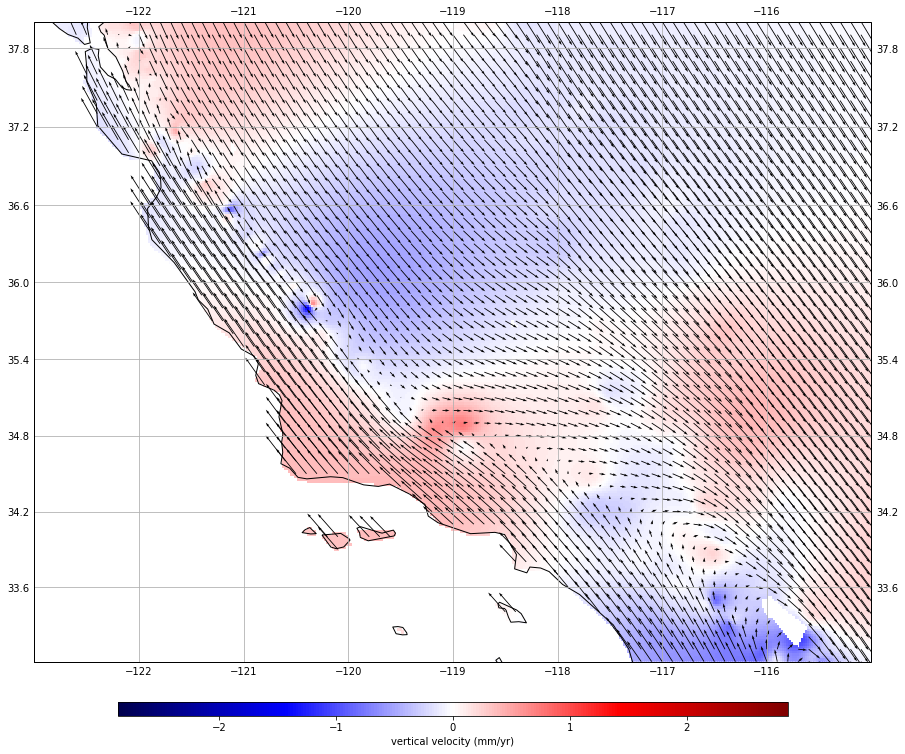

In [6]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, projection=ccrs.Mercator())
cbargs = dict(
    orientation="horizontal", aspect=50, pad=0.05,shrink=0.8, 
    label="vertical velocity (mm/yr)"
)
maxabs = vd.maxabs(grid.up_velocity)
synthetic_grid.up_velocity.plot.pcolormesh(
    ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic", cbar_kwargs=cbargs, 
    transform=ccrs.PlateCarree()
)
indexer = slice(None, None, 5)
# Downsample the arrows so we can actually see something
down = synthetic_grid.isel(longitude=indexer, latitude=indexer)
ax.quiver(down.longitude.values, down.latitude.values, 
          down.east_velocity.values, down.north_velocity.values, 
          scale=500, width=0.001, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines(resolution="50m")
ax.set_extent(region)

Save the grid to netCDF file for later use.

In [7]:
synthetic_grid.to_netcdf("../../data/synthetic-san-andreas-2017.nc")

Extract samples from the grid based on the real data from PBO.

In [8]:
pbo_coords = pd.read_csv(
    "../../data/pbo.final_nam08.vel", 
    skiprows=36, 
    usecols=[7, 8], 
    delim_whitespace=True
).values.T[::-1]
pbo_coords[0] -= 360
inside = vd.inside(pbo_coords, region)
pbo_coords = tuple(coord[inside] for coord in pbo_coords)

Extract sample from the grid.

In [9]:
data = sample_from_grid(
    synthetic_grid, coordinates=dict(longitude=pbo_coords[0], latitude=pbo_coords[1])
).dropna()
data

,east_velocity,north_velocity,up_velocity,longitude,latitude
0,1.183206,2.223193,-0.072251,-117.10,34.12
1,1.183206,2.223193,-0.072251,-117.10,34.12
2,1.183206,2.223193,-0.072251,-117.10,34.12
3,1.183206,2.223193,-0.072251,-117.10,34.12
4,1.183206,2.223193,-0.072251,-117.10,34.12
5,1.183206,2.223193,-0.072251,-117.10,34.12
6,-9.595565,10.843342,-0.337050,-117.44,33.28
7,-9.595565,10.843342,-0.337050,-117.44,33.28
8,10.403741,-8.335638,0.243337,-116.42,34.60
9,10.403741,-8.335638,0.243337,-116.42,34.60


Plot the samples.

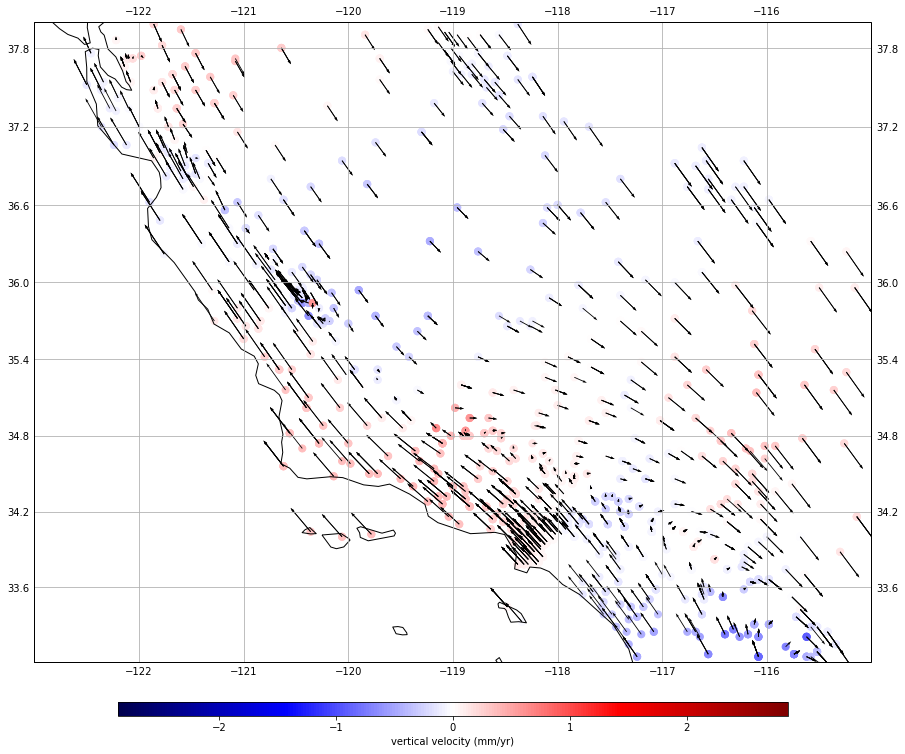

In [10]:
plt.figure(figsize=(15, 15))
ax = plt.subplot(111, projection=ccrs.Mercator())
cbargs = dict(
    orientation="horizontal", aspect=50, pad=0.05,shrink=0.8, 
    label="vertical velocity (mm/yr)"
)
maxabs = vd.maxabs(grid.up_velocity)
tmp = ax.scatter(
    data.longitude, data.latitude, c=data.up_velocity, s=50,
    vmin=-maxabs, vmax=maxabs, cmap="seismic", 
    transform=ccrs.PlateCarree()
)
plt.colorbar(tmp, ax=ax, **cbargs)
ax.quiver(data.longitude.values, data.latitude.values, 
          data.east_velocity.values, data.north_velocity.values, 
          scale=500, width=0.001, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines(resolution="50m")
ax.set_extent(region)

Save the synthetic data to a CSV file.

In [11]:
data.to_csv("../../data/synthetic-san-andreas-2017-samples.csv", index=False)